## train_models3

Train the models for mirroring - 2nd attemp!

## Step 1: Import modules

In [57]:
import os
import sys
import glob
import time
import pickle
import importlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zeno_face_tracker_helpers import *
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('zeno_interface', 'repository_path')))
from video_sources import *
from zeno_interface import *
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
from ibug_face_tracker import *
from zeno_face_tracker import *
print('All modules imported.')

All modules imported.


## Step 2: Load examples and split them into a training set and a validation set

In [34]:
examples = pd.read_pickle(os.path.realpath('./dataset2/all_enhanced_samples.pkl'))
examples = [examples.iloc[idx].to_dict() for idx in range(examples.shape[0])]
for example in examples:
    # Add aligned iris points into landmarks:
    left_iris = example['aligned_eye_points'][1:6].mean(axis=0)
    right_iris = example['aligned_eye_points'][8:13].mean(axis=0)
    example['aligned_landmarks'] = np.vstack((example['aligned_landmarks'], left_iris, right_iris))
print('All %d examples loaded.' % len(examples))
indices = np.random.permutation(len(examples))
validation_indices = indices[0: int(len(indices) / 5)]
training_indices = indices[len(validation_indices):]
training_examples = [examples[idx] for idx in training_indices]
validation_examples = [examples[idx] for idx in validation_indices]
print('We have %d training examples and %d validation examples.' % 
      (len(training_examples), len(validation_examples)))

All 5901 examples loaded.
We have 4721 training examples and 1180 validation examples.


## Step 3: Get default actuator values of the robot

In [35]:
zeno_head = None
try:
    zeno_head = ZenoHead(config.get('zeno_interface', 'zeno_ip_address'))
    default_actuator_values = zeno_head.get_default_motor_positions()
    print('The default actuator values are: ' + ', '.join(['%.06f' % x for x in default_actuator_values]))
finally:
    if zeno_head is not None:
        zeno_head.disconnect()

The default actuator values are: 0.502370, 0.778409, 0.502041, 0.872951, 0.500000, 0.501736, 0.157534


## Step 4: Compute the robot's neutral face shape by averging the examples closest to the default acutator values

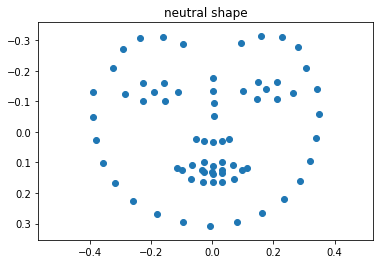

In [36]:
%matplotlib inline

actuator_values_tr = np.array([x['actuator_values'] for x in training_examples])
distances_to_neutral = [np.linalg.norm(x) for x in actuator_values_tr - default_actuator_values]
neutral_shape_indices = [idx for idx in range(len(distances_to_neutral)) if distances_to_neutral[idx] < 1e-2]
neutral_shape = np.array([training_examples[idx]['aligned_landmarks'] for idx in neutral_shape_indices]).mean(axis=0)

ax = plt.subplot(1, 1, 1)
plt.scatter(neutral_shape[:, 0], neutral_shape[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('neutral shape')
plt.show()

## Step 5: Calculate displacement from neutral face and build a 'shape model' around this

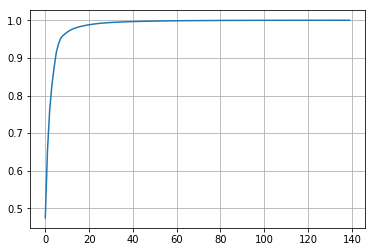

You need 35 dimensions to get 99.5% variation.


In [37]:
%matplotlib inline

for example in examples:
    example['displacement_from_neutral'] = example['aligned_landmarks'] - neutral_shape
flattened_displacement_tr = np.array([x['displacement_from_neutral'].flatten() for x in training_examples])
mean_tr = flattened_displacement_tr.mean(axis=0)
std_tr = flattened_displacement_tr.std(axis=0)
flattened_displacement_tr = np.divide(flattened_displacement_tr - mean_tr, std_tr)

eigen_values, eigen_vectors = np.linalg.eig(np.cov(flattened_displacement_tr.T))
eigen_values = np.real(eigen_values)
cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                           for x in range(len(eigen_values))]

plt.plot(cumulative_eigen_values)
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()

dims995 = len([x for x in cumulative_eigen_values if x <= 0.995]) + 1
print('You need %d dimensions to get 99.5%% variation.' % dims995)
pca_basis = np.real(eigen_vectors)
flattened_displacement_tr_pca = np.matmul(flattened_displacement_tr, pca_basis)

# Step 6: Train the model (currently just linear regression)!

In [38]:
actuator_values_tr = np.array([x['actuator_values'] for x in training_examples])
flattened_displacement_tr_pca_cut = flattened_displacement_tr_pca[:, 0: dims995]
lr_coefs = np.linalg.lstsq(np.hstack((flattened_displacement_tr_pca_cut, 
                                      np.ones((flattened_displacement_tr_pca_cut.shape[0], 1)))), 
                           actuator_values_tr, rcond=None)

# Test the stuff
actuator_values_val = np.array([x['actuator_values'] for x in validation_examples])
flattened_displacement_val = np.array([x['displacement_from_neutral'].flatten() for x in validation_examples])
flattened_displacement_val = np.divide(flattened_displacement_val - mean_tr, std_tr)
flattened_displacement_val_pca = np.matmul(flattened_displacement_val, pca_basis)
flattened_displacement_val_pca_cut = flattened_displacement_val_pca[:, 0: dims995]
predictions_val = np.matmul(np.hstack((flattened_displacement_val_pca_cut, 
                                       np.ones((flattened_displacement_val_pca_cut.shape[0], 1)))), 
                            lr_coefs[0])
errors = (predictions_val - actuator_values_val)
print('This is the MAE validation error: ')
print(np.abs(errors).mean(axis=0))

This is the MAE validation error: 
[0.01410409 0.0366411  0.04901702 0.02995797 0.08600465 0.04117203
 0.02782642]


# Step 7: Track the MultiPIE data

In [40]:
dataset_folder = os.path.realpath('./dataset3')
multipie_images = glob.glob(os.path.join(dataset_folder, '*.png'))
ert_model_path = config.get('facial_landmark_tracker', 'ert_model_path')
auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
tracker = FaceTracker(ert_model_path, auxiliary_model_path)
tracker.face_detection_scale = 2.0
tracker.minimum_face_size = 48
tracker.hard_failure_threshold = -1e6
multipie_landmarks = []
multipie_fitting_scores = []
for image_file in multipie_images:
    image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2GRAY)
    tracker.reset()
    tracker.track(image)
    if tracker.has_facial_landmarks:
        left_iris = np.mean(tracker.eye_landmarks[1:6], axis=0)
        right_iris = np.mean(tracker.eye_landmarks[7:13], axis=0)
        multipie_fitting_scores.append(tracker.most_recent_fitting_scores.astype(float))
        multipie_landmarks.append(np.vstack((tracker.facial_landmarks, left_iris, right_iris)).astype(float))
multipie_fitting_scores = np.array(multipie_fitting_scores).max(axis=1)
print('Done.')

Done.


## Step 7.1: Add CK into the mix

In [41]:
ck_folder = os.path.realpath('./dataset3/ck_landmarks/sorted_set')
landmark_files = glob.glob(os.path.join(ck_folder, '*/*.landmarks.txt'))
for landmark_file in landmark_files:
    with open(landmark_file) as landmarks:
        head_pose_line = landmarks.readline().replace('\r', '').replace('\n', '')
        eye_points_line = landmarks.readline().replace('\r', '').replace('\n', '')
        landmarks_line = landmarks.readline().replace('\r', '').replace('\n', '')
        tags_line = landmarks.readline().replace('\r', '').replace('\n', '')
        fitting_scores_line = landmarks.readline().replace('\r', '').replace('\n', '')
        validity = int(tags_line.split(' ')[0])
        if validity > 0:
            fitting_score = np.array([float(x) for x in fitting_scores_line.split(' ') if len(x) > 0]).max()
            facial_landmarks = np.array([float(x) for x in landmarks_line.split(' ') if len(x) > 0]).reshape(-1, 2)
            eye_points = np.array([float(x) for x in eye_points_line.split(' ') if len(x) > 0]).reshape(-1, 2)
            left_iris = np.mean(eye_points[0:5], axis=0)
            right_iris = np.mean(eye_points[5:], axis=0)
            multipie_landmarks.append(np.vstack((facial_landmarks, left_iris, right_iris)))
            multipie_fitting_scores = np.append(multipie_fitting_scores, fitting_score)
            multipie_images.append(landmark_file)
print('Done.')

Done.


## Step 8: Filter the MultiPIE landmarks and build 'shape model'

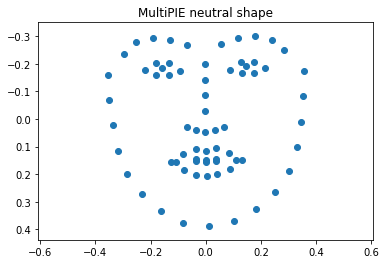

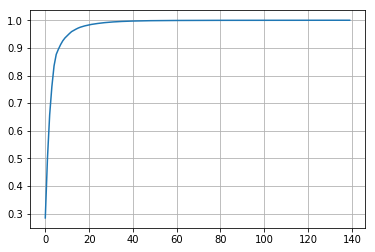

You need 35 dimensions to get 99.5% variation.


In [42]:
# Filter MultiPIE data
fitting_score_threshold = multipie_fitting_scores.mean() - 2 * multipie_fitting_scores.std()
multipie_data = [{'image_file': multipie_images[idx], 'landmarks': multipie_landmarks[idx]} 
                 for idx in range(len(multipie_fitting_scores)) 
                 if multipie_fitting_scores[idx] > fitting_score_threshold]

# Find the neutral faces
neutral_face_images = (glob.glob(os.path.join(dataset_folder, '*_01_01_050_*.png')) + 
                       glob.glob(os.path.join(dataset_folder, '*_01_01_140_*.png')) + 
                       glob.glob(os.path.join(ck_folder, 'neutral/*.landmarks.txt')))
multipie_data_neutral = [x for x in multipie_data if x['image_file'] in neutral_face_images]

# Caculate mean face
all_normalised_landmarks = []
for sample in multipie_data:
    face_size = np.linalg.norm(sample['landmarks'].max(axis=0) - sample['landmarks'].min(axis=0))
    all_normalised_landmarks.append((sample['landmarks'] - sample['landmarks'].mean(axis=0)) / face_size)
multipie_mean_shape = np.array(all_normalised_landmarks).mean(axis=0)

# Align everything to the mean face
anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
    ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
for sample in multipie_data:
    transform = compute_rigid_alignment_parameters(sample['landmarks'][anchors], multipie_mean_shape[anchors])
    sample['aligned_landmarks'] = apply_rigid_alignment_parameters(sample['landmarks'], *transform)

# Get neutral shape
multipie_neutral_shape = np.array([x['aligned_landmarks'] for x in multipie_data_neutral]).mean(axis=0)
ax = plt.subplot(1, 1, 1)
plt.scatter(multipie_neutral_shape[:, 0], multipie_neutral_shape[:, 1])
ax.set_aspect('equal', 'datalim')
ax.invert_yaxis()
plt.title('MultiPIE neutral shape')
plt.show()

# Calculate displacement from neutral shape
for sample in multipie_data:
    sample['displacement_from_neutral'] = sample['aligned_landmarks'] - multipie_neutral_shape

# PCA the displacements
multipie_flattened_displacement = np.array([x['displacement_from_neutral'].flatten() for x in multipie_data])
multipie_mean = multipie_flattened_displacement.mean(axis=0)
multipie_std = multipie_flattened_displacement.std(axis=0)
multipie_flattened_displacement = np.divide(multipie_flattened_displacement - multipie_mean, multipie_std)

eigen_values, eigen_vectors = np.linalg.eig(np.cov(multipie_flattened_displacement.T))
eigen_values = np.real(eigen_values)
cumulative_eigen_values = [np.sum(eigen_values[0: x + 1]) / np.sum(eigen_values) 
                           for x in range(len(eigen_values))]

plt.plot(cumulative_eigen_values)
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
plt.show()

multipie_dims995 = len([x for x in cumulative_eigen_values if x <= 0.995]) + 1
print('You need %d dimensions to get 99.5%% variation.' % multipie_dims995)
multipie_pca_basis = np.real(eigen_vectors)

## Step 9: Test the model on live video!

In [54]:
zeno_head = None
video_source = None
try:
    anchors = [int(x) for x in config.get('data_organisation', 'alignment_anchors').strip().replace(
        ' ', '').replace('\'', '').replace('\"', '').split(',') if len(x) > 0]
#     anchors = list(range(70))
    zeno_head = ZenoHead(config.get('zeno_interface', 'zeno_ip_address'))
    video_source = ThreadedWebcam(0, 640, 480, 30.0)

#     window_title_re = config.get('window_specification', 'title_re')
#     window_class_name = config.get('window_specification', 'class_name')
#     child_identifier = config.get('window_specification', 'child_identifier')
#     window_roi = config.get('window_specification', 'window_roi').replace(
#         '\'', '').replace('\"', '').replace('\t', '').replace(' ', '')
#     window_roi = tuple([float(x) for x in window_roi.split(',') if len(x) > 0])
#     pywinauto = importlib.import_module('pywinauto')
#     top_level_window = pywinauto.Desktop(backend='win32').window(title_re=window_title_re,
#                                                                  class_name=window_class_name,
#                                                                  visible_only=False)
#     if len(child_identifier) > 0:
#         window_handle = top_level_window[child_identifier].handle
#     else:
#         window_handle = top_level_window.handle
#     video_source = ThreadedWindowCapture(window_handle, 640, 480, 30.0, window_roi)
    
    ert_model_path = config.get('facial_landmark_tracker', 'ert_model_path')
    auxiliary_model_path = config.get('facial_landmark_tracker', 'auxiliary_model_path')
    tracker = FaceTracker(ert_model_path, auxiliary_model_path)
    
    while True:
        is_new_frame, frame = video_source.read(0.01)
        if is_new_frame:
            tracker.track(frame)
            if tracker.has_facial_landmarks:
                left_iris = tracker.eye_landmarks[1:6, :].mean(axis=0)
                right_iris = tracker.eye_landmarks[8:13, :].mean(axis=0)
                all_landmarks = np.vstack((tracker.facial_landmarks, left_iris, right_iris)).astype(float)
                transform = compute_rigid_alignment_parameters(all_landmarks[anchors], multipie_mean_shape[anchors])
                aligned_landmarks = apply_rigid_alignment_parameters(all_landmarks, *transform)
                displacement = aligned_landmarks - multipie_neutral_shape
                
                flattened_displacement = np.divide(displacement.flatten() - multipie_mean, multipie_std)
                flattened_displacement_recon = np.matmul(np.matmul(flattened_displacement, 
                                                                   multipie_pca_basis[:, 0:multipie_dims995]), 
                                                         multipie_pca_basis[:, 0:multipie_dims995].T)
                feature = np.matmul(flattened_displacement_recon, pca_basis[:, 0:dims995])

#                 flattened_displacement = np.divide(displacement.flatten() - mean_tr, std_tr)
#                 feature = np.matmul(flattened_displacement, pca_basis[:, 0:dims995])
            
                actuator_values = np.matmul(feature.tolist() + [1], lr_coefs[0])
                zeno_head.move(np.clip(actuator_values, 0.0, 1.0), 40)
                print(actuator_values)
            tracker.plot_current_result(frame)
            cv2.imshow('Tracking', frame)
        key = cv2.waitKey(10)
        if key == ord('q') or key == ord('Q'):
            break
finally:
    cv2.destroyAllWindows()
    if video_source is not None:
        video_source.release()
    if zeno_head is not None:
        zeno_head.reset(400)
        time.sleep(1.0)
        zeno_head.disconnect()

[0.38216581 0.45304249 1.32228262 0.86134712 0.66744437 0.91085792
 0.11852391]
[0.37560538 0.42683277 1.23677678 0.85596021 0.8017646  0.95073877
 0.134683  ]
[0.36963421 0.42577279 1.21563603 0.85173388 0.75932851 0.94724004
 0.14715   ]
[0.37344814 0.40531977 1.2128826  0.85280394 0.77459593 0.94211806
 0.1516759 ]
[0.37178799 0.42005149 1.22525605 0.83727167 0.74539472 0.94835287
 0.12755591]
[0.36838647 0.40858216 1.23882454 0.86215699 0.79992995 0.93529161
 0.11909636]
[0.37572139 0.40223529 1.30614694 0.88093494 0.929885   0.9550084
 0.14553108]
[0.36321218 0.36976383 1.30587876 0.87994322 0.94961581 0.96584063
 0.12156793]
[0.3587823  0.27353564 1.34353565 0.81348024 1.02063594 0.96989992
 0.09689652]
[0.35504696 0.24566579 1.28806621 0.80864656 1.01273758 0.93093029
 0.10218484]
[0.35240549 0.25109131 1.28348458 0.86981486 1.10436483 0.99460578
 0.08765211]
[0.35074882 0.25049579 1.26560848 0.80337648 1.24051929 0.99258972
 0.07946332]
[0.3249775  0.25215947 1.15484464 0.72023

In [68]:
# Save the model
model = {}
model['mean_shape'] = multipie_mean_shape
model['neutral_shape'] = multipie_neutral_shape
model['multipie_pca_basis'] = multipie_pca_basis[:, 0:multipie_dims995]
model['pca_basis'] = pca_basis[:, 0:dims995]
model['lr_coefs'] = lr_coefs
model['multipie_mean'] = multipie_mean
model['multipie_std'] = multipie_std
model['mean_tr'] = mean_tr
model['std_tr'] = std_tr
model['zeno_neutral_shape'] = neutral_shape
model['zeno_mean_shape'] = np.array([x['aligned_landmarks'] for x in examples]).mean(axis=0)
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file, protocol=2)
print('Model saved to model.pkl.')

Model saved to model.pkl.
